# Community detection in complex networks

Basics:
* Communities are **locally dense connected subgraphs** in a network.
* Community detection aims to uncover the inherent community structure of a network.

Definitions:
* Clique - a fully connected subgraph within a larger graph.
* Strong community - each node has more edges connecting it to other nodes inside the group than to nodes outside the group.
* Weak community - the total internal degree of the group exceeds its total external degree.

Approaches and algorithms:
* Graph partitioning
* Hierarchical clustering (Girvan–Newman)
* Modularity optimization (Louvain)

## Introduction to community detection

Lets start with a simple example of a small graph.

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

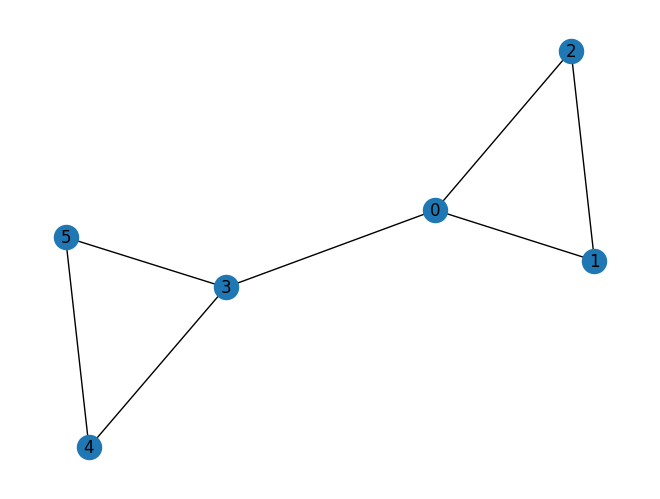

In [2]:
G = nx.Graph()
nx.add_cycle(G, [0, 1, 2])
nx.add_cycle(G, [3, 4, 5])
G.add_edge(0, 3)

nx.draw(G, with_labels=True)

How can we devide this graph into communities to get partitions of good quality? At first we'll do it by hand and validate if the partition is valid.

In [3]:
partition = [
    {0, 1, 2},
    {3, 4, 5},
]

nx.community.is_partition(G, partition)

True

Now, create a mapping between nodes and partitions, that will be of use for visualization and assesment of partition quality.

In [4]:
def create_node_to_partition_mapping(partition):
  node_to_partition = {}
  for idx, cluster_nodes in enumerate(partition):
      for node in cluster_nodes:
          node_to_partition[node] = idx
  return node_to_partition

node_to_partition = create_node_to_partition_mapping(partition)
node_to_partition

{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1}

Then visualize this simple graph again with color of nodes corresponding to the partition they belong to.

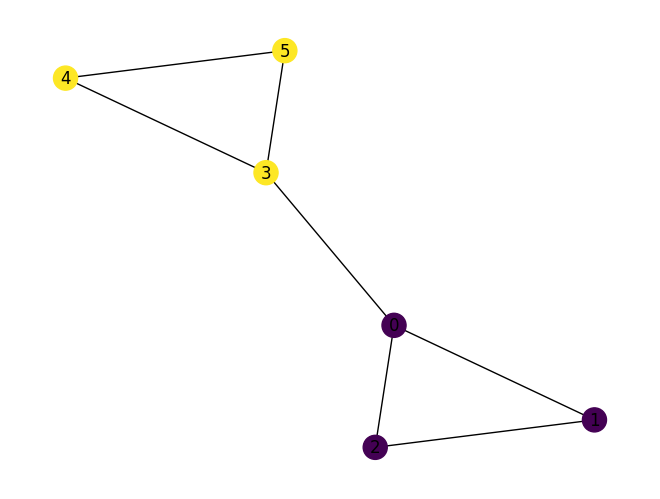

In [5]:
colors = [node_to_partition[n] for n in G.nodes]
nx.draw(G, node_color=colors, with_labels=True)

## Modularity

Now with the defined partition, we need to look for an answer to the question of can we evaluate the goodness of this network partition, and in a broader context, any partition of any graph?

One possible answer is to compare the connection density of the groups to a random baseline, as random networks do not have groups.

The modularity measure is defined as the difference between the number of internal links in the clusters and the expected number of links in a random network.

$$Q = \frac{1}{L}\sum_C(L_C - \frac{k_C^2}{4L})$$

where:
- $L$ - total number of links
- $L_c$ - number of links inside cluster $C$
- $\frac{k_C^2}{4L}$ - number of links in a random network

NetworkX comes with an efficient implementation of modularity calculation ```nx.community.quality.modularity(G, partition)```, that we will use to measure partition quality.

In [6]:
nx.community.quality.modularity(G, partition)

0.35714285714285715

We can verify how the modularity value change if we decide to change the partition.

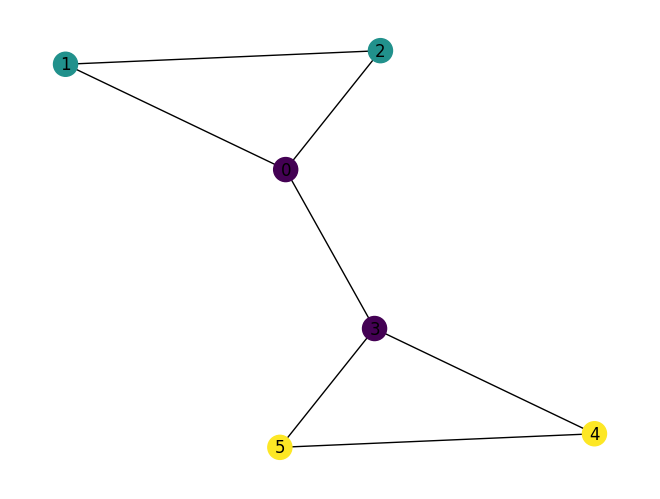

In [7]:
partition2 = [
    {0, 3},
    {1, 2},
    {4, 5},
]

colors = [create_node_to_partition_mapping(partition2)[n] for n in G.nodes]
nx.draw(G, node_color=colors, with_labels=True)

In [8]:
nx.community.quality.modularity(G, partition2)

0.0816326530612245

## Setting up networks for study

In the next sections of this notebook, we will be working with different networks, both artificial and real-world and algorithms that will help us identify communities within those networks.

In [9]:
connected_caveman_graph = nx.connected_caveman_graph(4, 8)
small_world_network = nx.watts_strogatz_graph(34, 4, 0.15)
windmill_graph = nx.windmill_graph(5, 7)
gaussian_random_partition_graph = nx.gaussian_random_partition_graph(n=34, s=9, v=9, p_in=0.7, p_out=0.03, seed=42)
random_partition_graph = nx.random_partition_graph([10, 8, 5, 5, 3, 3], 0.8, 0.04, seed=42)
karate_club_network = nx.karate_club_graph()

### Task 1
The first task is to take a look at the networks that are going to be the subject of study. Prepare a visualization of the graphs defined in the previous cell. Place all of them on a single plot, remember to include subplot titles to be able to identify them and find the best positionig that helps to reveale the network structure.

#### Code

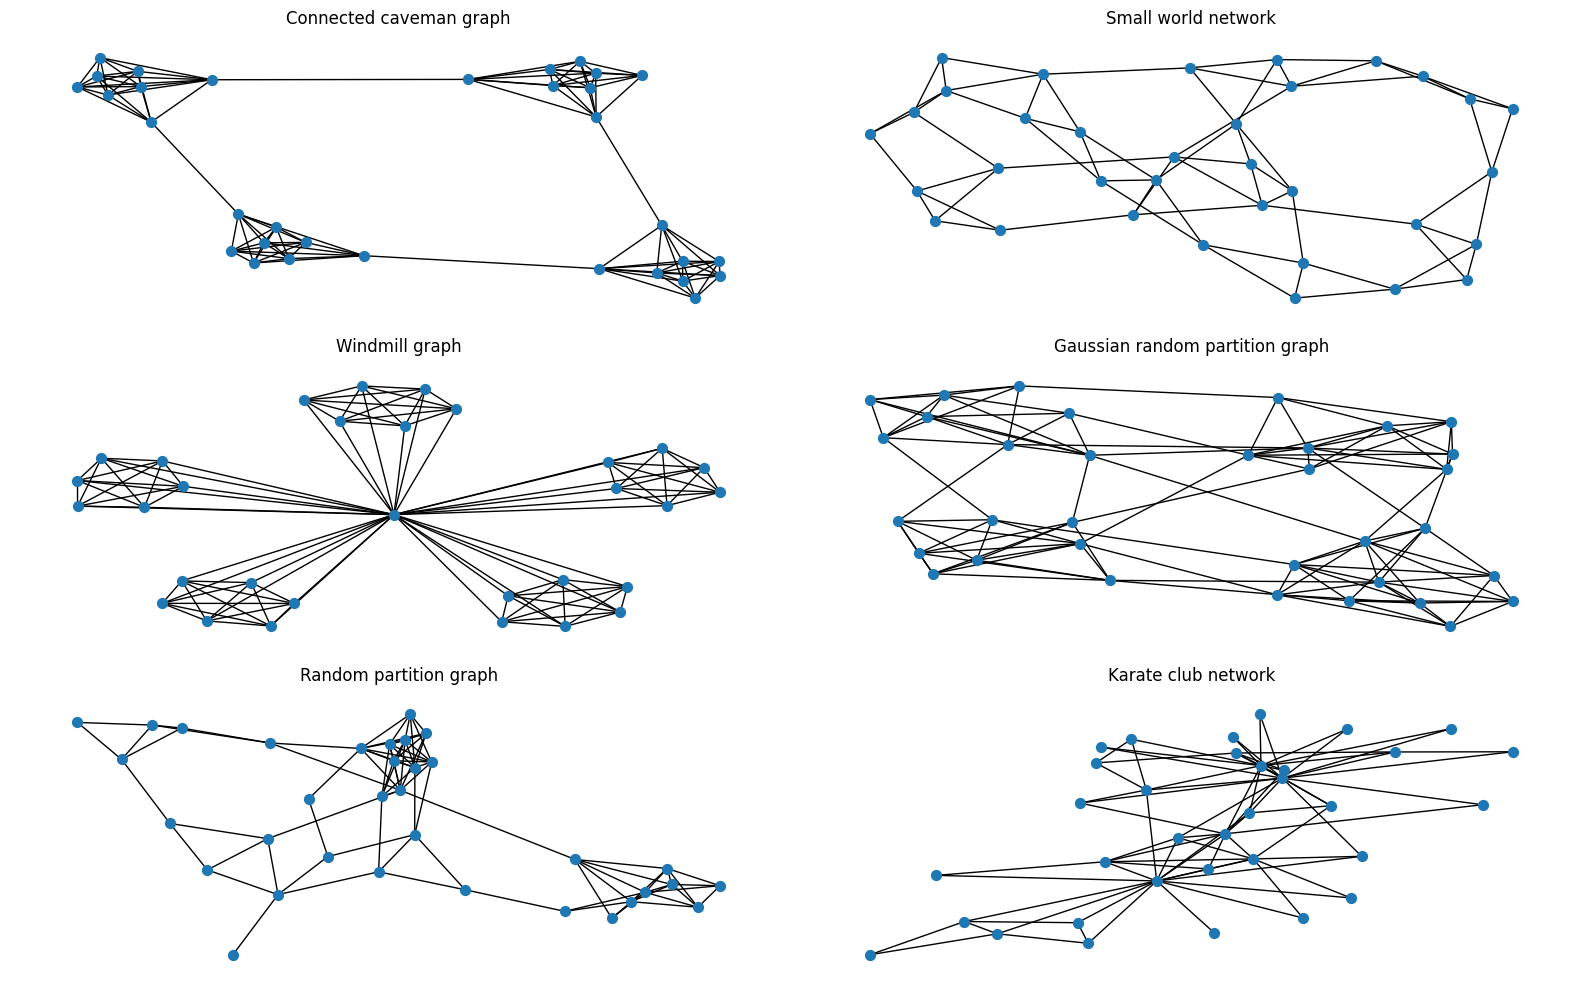

In [10]:
plot, axes = plt.subplots(3, 2, figsize=(16, 10))

nx.draw(connected_caveman_graph, ax=axes[0, 0], node_size=50)
axes[0, 0].set_title("Connected caveman graph")
nx.draw(small_world_network, pos=nx.spring_layout(small_world_network), ax=axes[0, 1], node_size=50)
axes[0, 1].set_title("Small world network")
nx.draw(windmill_graph, ax=axes[1, 0], node_size=50)
axes[1, 0].set_title("Windmill graph")
nx.draw(gaussian_random_partition_graph, ax=axes[1, 1], node_size=50)
axes[1, 1].set_title("Gaussian random partition graph")
nx.draw(random_partition_graph, pos=nx.spring_layout(random_partition_graph), ax=axes[2, 0], node_size=50)
axes[2, 0].set_title("Random partition graph")
nx.draw(karate_club_network, pos=nx.spring_layout(karate_club_network), ax=axes[2, 1], node_size=50)
axes[2, 1].set_title("Karate club network")

plot.tight_layout()

## Cliques identification

### Task 2
Calculate the number of different size cliques present in each network and visualize them on a barplot.

Analyse and interpret the obtained results, write your conclusions in the cell below. What does the number of cliques says about those networks? Are they differnt or quite similar?

#### Code

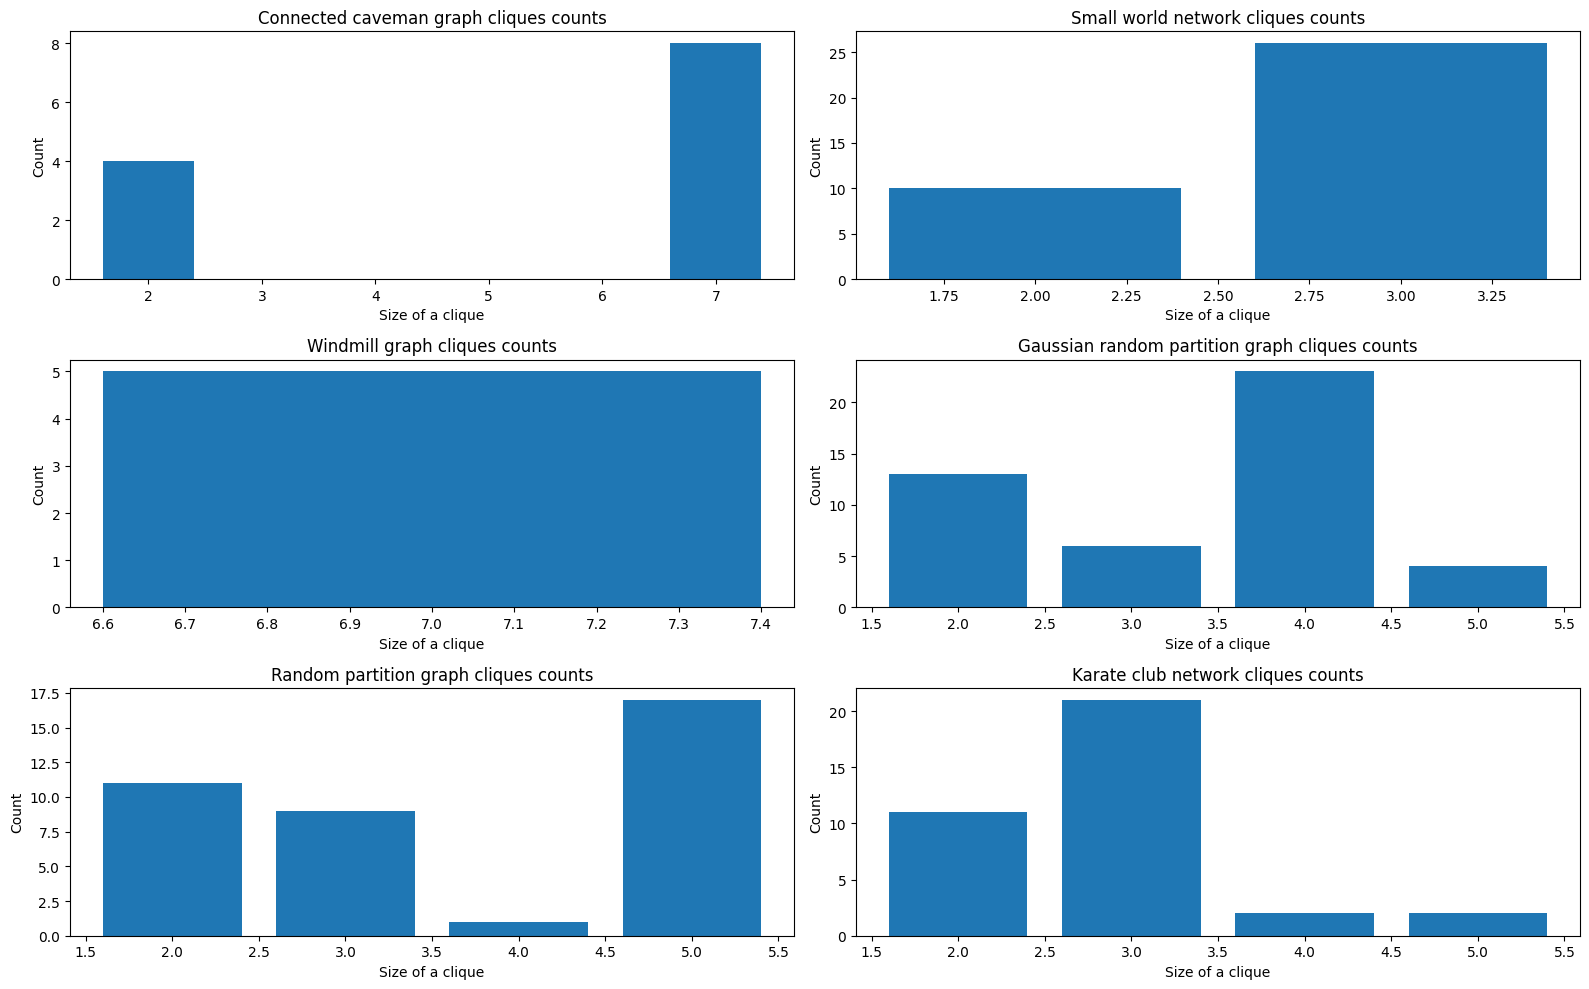

In [11]:
def create_barplot(data, ax, graph_name):
    cliques = [len(i) for i in nx.find_cliques(data)]
    y_vals = [i for i in range(min(cliques), max(cliques) + 1)]
    heights = [0] * len(y_vals)
    for t in cliques:
        heights[t - min(cliques)] += 1
    ax.bar([i for i in range(min(cliques), max(cliques) + 1)], height=heights)
    ax.set_title(f"{graph_name} cliques counts")
    ax.set_xlabel("Size of a clique")
    ax.set_ylabel("Count")

plot, axes = plt.subplots(3, 2, figsize=(16, 10))

create_barplot(connected_caveman_graph, axes[0, 0], "Connected caveman graph")
create_barplot(small_world_network, axes[0, 1], "Small world network")
create_barplot(windmill_graph, axes[1, 0], "Windmill graph")
create_barplot(gaussian_random_partition_graph, axes[1, 1], "Gaussian random partition graph")
create_barplot(random_partition_graph, axes[2, 0], "Random partition graph")
create_barplot(karate_club_network, axes[2, 1], "Karate club network")

plot.tight_layout()

#### Conclusions

Random partition graph, karate club network and gaussian random partition graph are similar to each other - they contain cliques from size 2 to 5.  
Other graphs are different from each others, containing different distribution of cliques.

## Hierarchical clustering using Girvan–Newman algorithm

The Girvan–Newman algorithm is a popular method for detecting communities in complex networks. It is based on the concept of edge betweenness centrality and operates by iteratively removing edges with the highest betweenness centrality. This process effectively breaks the network into smaller components, which can then be interpreted as communities.

The algorithm's steps
1. The betweenness of all existing edges in the network is calculated first.
2. The edge(s) with the highest betweenness are removed.
3. The betweenness of all edges affected by the removal is recalculated.
4. Steps 2 and 3 are repeated until no edges remain.

### Task 3
Use Girvan–Newman algorithm to detect communities among all studied networks. Use NetworkX function ```nx.algorithms.community.girvan_newman(G)```. Visualize and inspect obtained results for different numbers of communities. Find the best split for each network using modularity as a goodness measure and plot partitioned networks. Save the modularity results for each network for later comparison with other community detection method.

#### Code

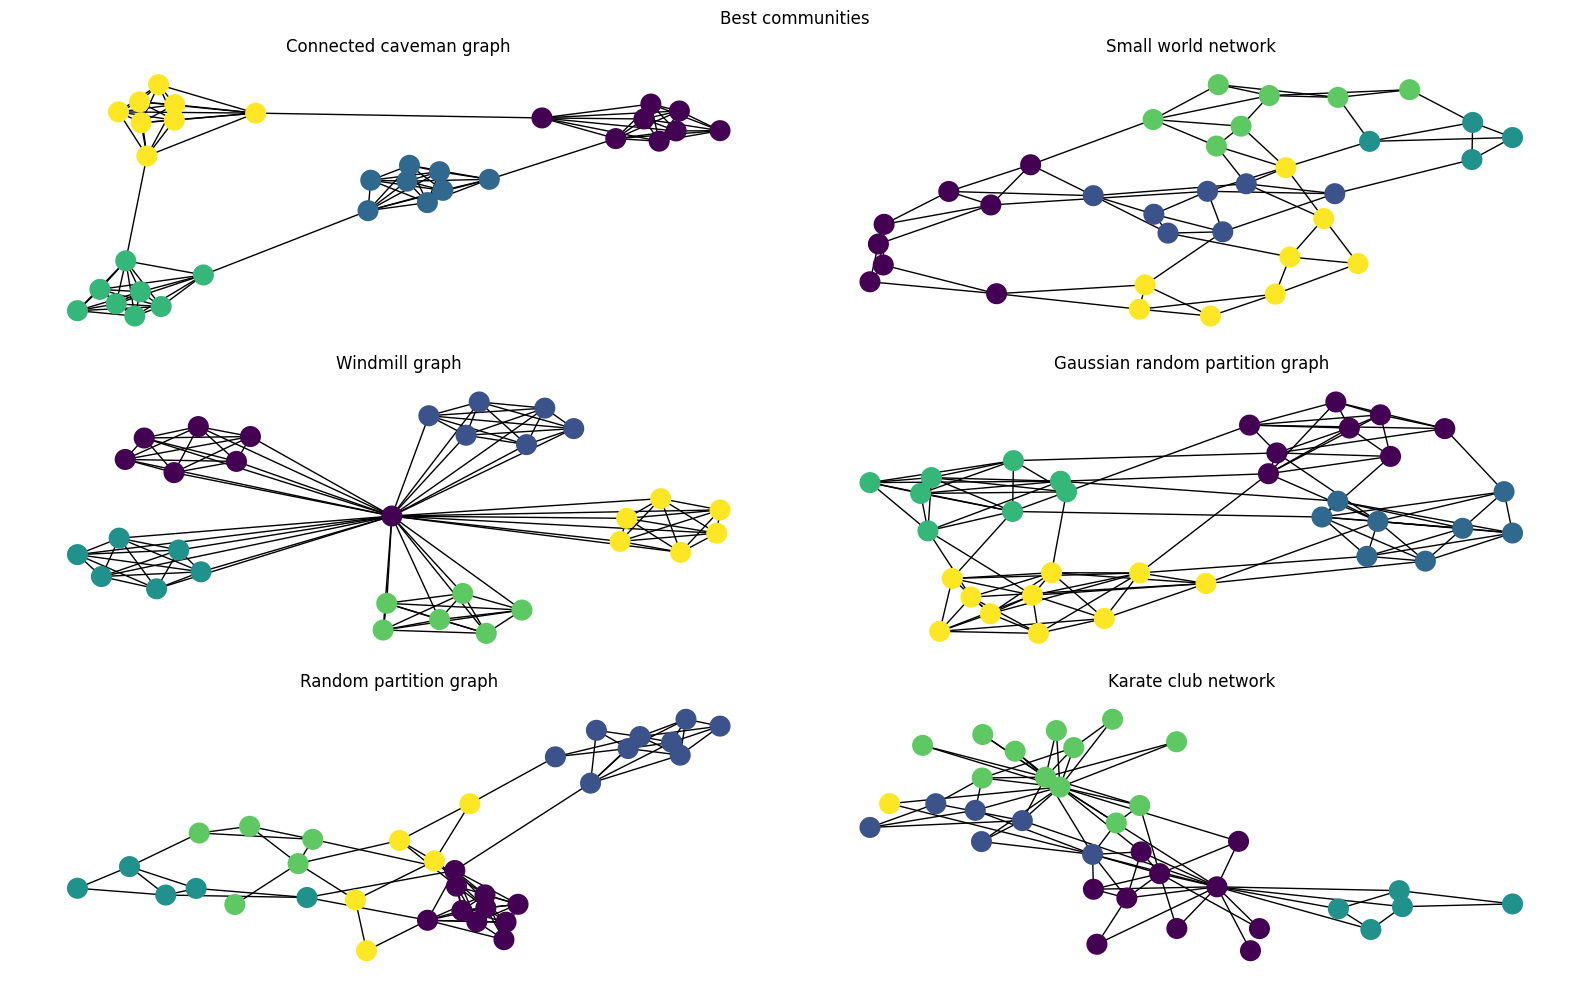

In [12]:
best_modularities_gn = {}

def plot_communities(graph, ax, graph_name):
    comms = [i for i in nx.algorithms.community.girvan_newman(graph)]
    best = max(comms, key=lambda part: nx.community.quality.modularity(graph, part))
    colors = [create_node_to_partition_mapping(best)[n] for n in graph.nodes]
    nx.draw(graph, node_color=colors, node_size=200, ax=ax)
    ax.set_title(graph_name)
    return max([nx.community.quality.modularity(graph, part) for part in comms])

plot, axes = plt.subplots(3, 2, figsize=(16, 10))

best_modularities_gn["connected_caveman_graph"] = plot_communities(connected_caveman_graph, axes[0, 0], "Connected caveman graph")
best_modularities_gn["small_world_network"] = plot_communities(small_world_network, axes[0, 1], "Small world network")
best_modularities_gn["windmill_graph"] = plot_communities(windmill_graph, axes[1, 0], "Windmill graph")
best_modularities_gn["gaussian_random_partition_graph"] = plot_communities(gaussian_random_partition_graph, axes[1, 1], "Gaussian random partition graph")
best_modularities_gn["random_partition_graph"] = plot_communities(random_partition_graph, axes[2, 0], "Random partition graph")
best_modularities_gn["karate_club_network"] = plot_communities(karate_club_network, axes[2, 1], "Karate club network")

plot.suptitle("Best communities")
plot.tight_layout()

## Modularity based community detection using Louvain algorithm
The Louvain algorithm is the most popular community detection algorithm. Its operation is based on the optimization of modularity. Louvain can be used even with very large networks with millions of nodes and edges.

### Louvain algorithm
1. Start with each node assigned to its own group.
2. Loop over nodes:

  2.1. Assign the node to the neighbor community that will give you the largest modularity increase.

  2.2. Repeat step 2.1 until no further modularity increase is possible.
3. Transform your network into a super network.

  3.1. Each community becomes a supernode.

  3.2. Assign weights to the edges corresponding to the number of connections within and between the groups.
4. Repeat step 2 until no further modularity increase is possible.


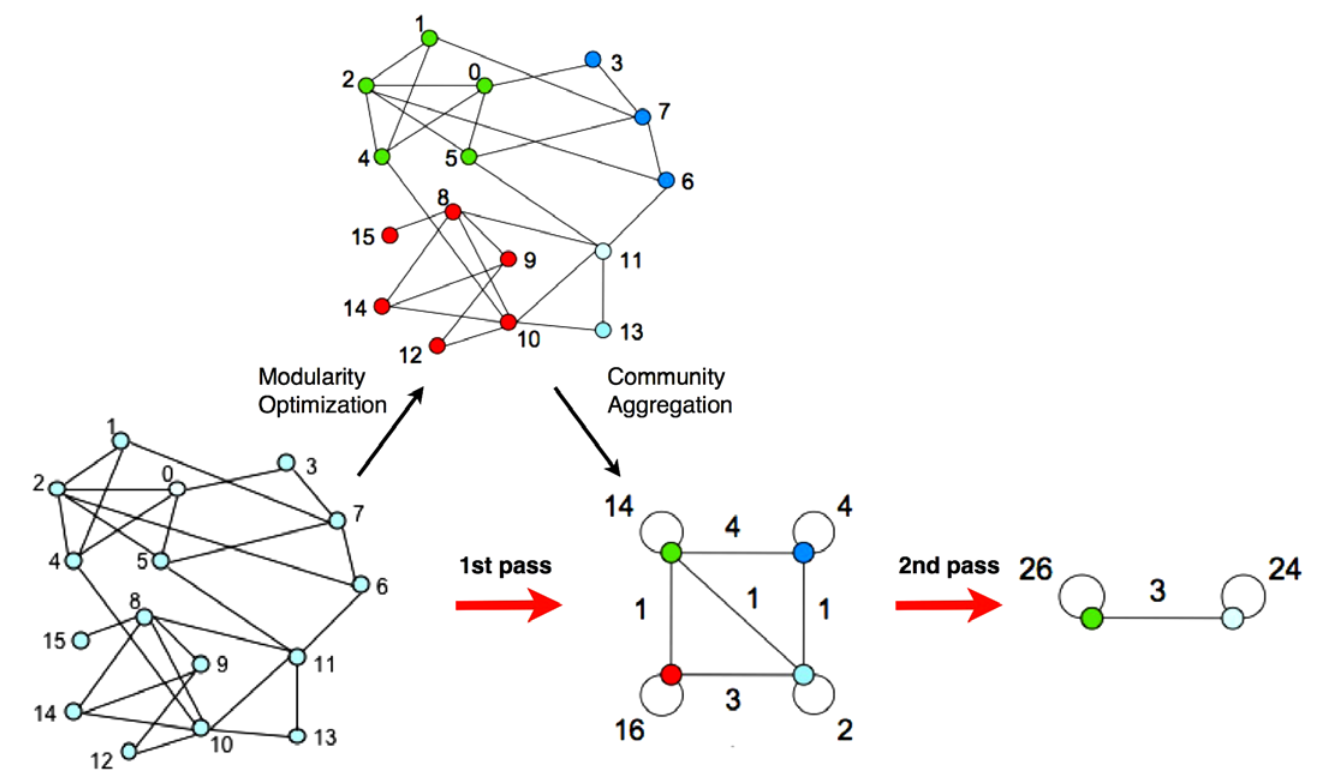

### Task 4
Use Louvain algorithm to detect communities among all studied networks. Use NetworkX function ```nx.community.louvain_communities(G, seed)```. Visualize and inspect the results.

Analyse and interpret the obtained communities, write your conclusions in the cell below.

 - Can we consider the produced split an optimal one? Change the seed value and check how it influences the obtained results, can you explain why the splits are sometimes different?

 - Compare the modularity value for generated partitions between Louvain algorithm and Girvan-Newmann algorithm. Which one is better in your opinion?

#### Code

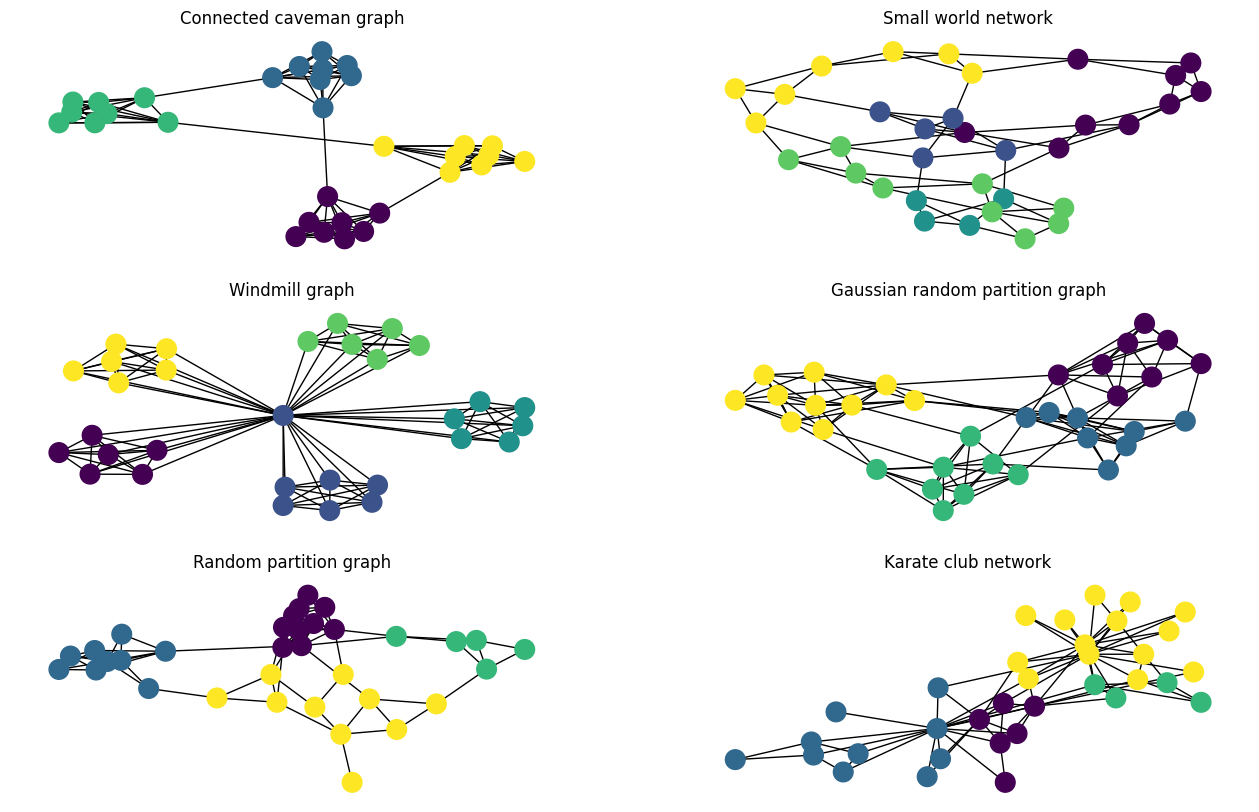

In [23]:
best_modularities_lv = {}
def plot_louv_communities(graph, ax, graph_name, seed=None):
    comm = [i for i in nx.community.louvain_communities(graph, seed=seed)]
    colors = [create_node_to_partition_mapping(comm)[n] for n in graph.nodes]
    nx.draw(graph, node_color=colors, node_size=200, ax=ax)
    ax.set_title(graph_name)
    return nx.community.quality.modularity(graph, comm)

plot, axes = plt.subplots(3, 2, figsize=(16, 10))

best_modularities_lv["connected_caveman_graph"] = plot_louv_communities(connected_caveman_graph, axes[0, 0], "Connected caveman graph")
best_modularities_lv["small_world_network"] = plot_louv_communities(small_world_network, axes[0, 1], "Small world network", 42)
best_modularities_lv["windmill_graph"] = plot_louv_communities(windmill_graph, axes[1, 0], "Windmill graph", 42)
best_modularities_lv["gaussian_random_partition_graph"] = plot_louv_communities(gaussian_random_partition_graph, axes[1, 1], "Gaussian random partition graph")
best_modularities_lv["random_partition_graph"] = plot_louv_communities(random_partition_graph, axes[2, 0], "Random partition graph")
best_modularities_lv["karate_club_network"] = plot_louv_communities(karate_club_network, axes[2, 1], "Karate club network", 42)

In [25]:
import pandas as pd

cols = {"Girvan-Newman": best_modularities_gn.values(), "Louvain": best_modularities_lv.values()}
pd.DataFrame(cols, index=["Connectec caveman", "Small world", "Windmill", "Gaussian random partition", "Random partition", "Karate club"])

,Girvan-Newman,Louvain
Connectec caveman,0.714286,0.714286
Small world,0.537630,0.543361
Windmill,0.555102,0.555102
Gaussian random partition,0.590902,0.590902
Random partition,0.564133,0.569436
Karate club,0.384972,0.426622


#### Conclusions

Splits are not always the same. This is a result of the fact, that Louvain algorithm is non-deterministic - particular nodes are one time a part of different communities depending on the seed value. That is why the resulting split is not always a globally optimal one.  
Louvain algorithm results in better or equal modularities than Girvan-Newman algorithm.

## Modularity,  communities and the graph structure

### Task 5
Generate a set of artificial networks of different types (scale-free netowrks, small-world networks, random partition graphs, ...) and with varying properties (size, connectivity, ...).

Study the relationship between network metrics like average centrality measures (degree, betweenness, closeness), clustering coefficient, etc. and modularity value of partition generated with Louvain algorithm as well as number of identified communities.

Analyse and interpret the obtained results, write your conclusions in the cell below.

#### Code

In [85]:
networks = [nx.scale_free_graph(200), 
            nx.navigable_small_world_graph(20), 
            nx.random_partition_graph([50, 50, 30, 15, 10, 8, 5], 0.2, 0.01), 
            nx.erdos_renyi_graph(70, 0.05), 
            nx.barabasi_albert_graph(20, 5)]
networks_with_no_multiedges = [nx.Graph(g) for g in networks]
net_names = ["scale_free", "small_world", "random_partition_graph", "erdos_renyi", "barabasi_albert"]

In [93]:
cols = {}
cols["Nodes count"] = [g.number_of_nodes() for g in networks]
cols["Edges count"] = [g.number_of_edges() for g in networks]
betweenness = [nx.betweenness_centrality(g) for g in networks]
cols["Mean betweenness"] = [sum(b.values()) / len(b) for b in betweenness]
closeness = [nx.closeness_centrality(g) for g in networks]
cols["Mean closeness"] = [sum(c.values()) / len(c) for c in closeness]
degrees = [nx.degree(g) for g in networks]
cols["Mean degree"] = [sum(dict(d).values()) / len(d) for d in degrees]
cols["Avg clustering coeficient"] = [nx.average_clustering(g) for g in networks_with_no_multiedges]
cols["Number of connected components"] = [nx.number_connected_components(g) for g in networks_with_no_multiedges]
communities = [[i for i in nx.community.louvain_communities(g)] for g in networks]
cols["Modularity"] = [nx.community.quality.modularity(g, c) for g, c in zip(networks, communities)]
cols["Communities count"] = [len(c) for c in communities]

pd.DataFrame(cols, index=net_names)

,Nodes count,Edges count,Mean betweenness,Mean closeness,Mean degree,Avg clustering coeficient,Number of connected components,Modularity,Communities count
scale_free,200,450,0.000795,0.026404,4.500000,0.138438,1,0.355714,11
small_world,400,1818,0.012680,0.168028,9.090000,0.087881,1,0.719565,12
random_partition_graph,168,730,0.011749,0.337941,8.690476,0.160826,2,0.536517,7
erdos_renyi,70,131,0.028772,0.296175,3.742857,0.050794,4,0.435522,10
barabasi_albert,20,75,0.035088,0.622276,7.500000,0.436923,1,0.116000,5


#### Conclusions

It is hard to say whether any of the metrics is related to modularity. Modularity dependend on number of links between nodes in and out of clusters. Only metric that seems to be relevant is average clustering coefficient - for higher values the modularity is lower.

## Real world data use-case
The data is a history of internal e-mail communication (`sender, recipient, datetime`) between employees of a mid-sized manufacturing company. Multiple recipients of the same e-mail (`To, CC, BCC`) are represented as separate rows without distinguishing the recipient type. The period covered are nine full months (event dates in local time). The file containing the communication events is named `communication.csv`.

Apart from the communication, information about who in the company reports to whom is attached (`reportsto.csv`). Node #86 is CEO.

### Data preparation

In [94]:
!apt install libgraphviz-dev
!pip install pygraphviz

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


Load raw events data

In [94]:
import requests
from pathlib import Path

data_file = Path("communication.tab")
if not data_file.exists():
    r = requests.get("https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/6Z3CGX/KWTRDM")
    with open(data_file, "w") as file:
        file.write(r.text.replace('"', ''))

# alternatively download from:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6Z3CGX#

raw_df = pd.read_table(data_file, sep=';', header=0,  parse_dates=["EventDate"])

Load company hierarchy

In [95]:
data_file = Path("reportsto.tab")
if not data_file.exists():
    r = requests.get("https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/6Z3CGX/SMALXX")
    with open(data_file, "w") as file:
        file.write(r.text.replace('"', ''))

# alternatively download from:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6Z3CGX#

reportsto = pd.read_csv(data_file, sep=";")

Clean dataset

In [96]:
non_employee_accounts = reportsto[reportsto.ReportsToID.apply(lambda x: not x.isnumeric())]
rows_to_remove = raw_df.loc[raw_df["Sender"].isin(non_employee_accounts["ID"]) | raw_df["Recipient"].isin(non_employee_accounts["ID"])]
raw_df = raw_df.drop(rows_to_remove.index)
reportsto = reportsto.drop(non_employee_accounts.index)

Plot company hierarchy

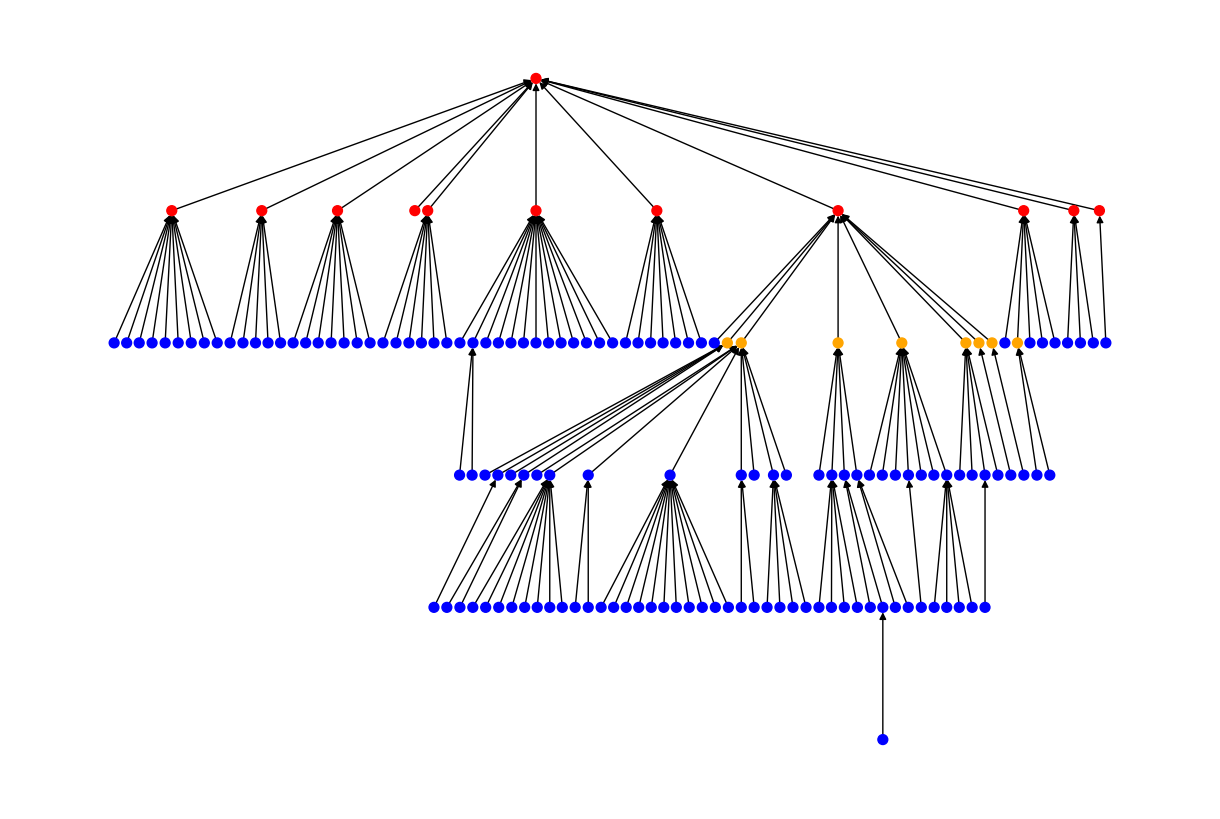

In [97]:
first_management_level = [86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163]
second_management_level = [76, 90, 136, 137, 143, 152, 47, 162]

H = nx.DiGraph()

for index, row in reportsto.iterrows():
  employee = row['ID']
  supervisor = int(row['ReportsToID'])
  communication_nodes = set(raw_df["Sender"].values + raw_df["Recipient"].values)
  if employee != supervisor and (employee in communication_nodes or supervisor in communication_nodes):
    H.add_edge(employee, supervisor)

color_map = []
for node in H:
  if node in first_management_level:
    color_map.append("red")
  elif node in second_management_level:
    color_map.append("orange")
  else:
    color_map.append("blue")

plt.figure(figsize=(12, 8))
pos_hierarchic = nx.nx_agraph.graphviz_layout(H, prog='dot')
pos_hierarchic = {node: (x,-y) for (node, (x,y)) in pos_hierarchic.items()}
nx.draw(H, pos=pos_hierarchic, with_labels=False, arrows=True, node_size=50, node_color=color_map)

plt.show()

### Task 6
Create a weighted network from the communication data.
Check if you can find communities in this real world network. Try different algorithms and approaches.

Can weight of the edges be used in that context? What type of graph representation can be an input to the community detection method you use?

Visualize communities using hirarchy positioning defined in the cell above. For the clarity of visualizations, use only edges from hierarchy company structure.

Analyse and interpret the obtained results, write your conclusions in the cell below. Answer the question: How can this kind of network analysis and exploration be leveraged in the company to improve its functioning?

#### Code

In [117]:
weighted_network = nx.DiGraph()

for index, row in raw_df.iterrows():
    if weighted_network.has_edge(row["Sender"], row["Recipient"]):
        weighted_network[row["Sender"]][row["Recipient"]]["weight"] += 1
    else:
        weighted_network.add_edge(row["Sender"], row["Recipient"], weight=1)
for n in H.nodes:
    if n not in weighted_network.nodes:
        weighted_network.add_node(n)

Communities based on Louvain algorithm

Modularity: 0.39966168322704243


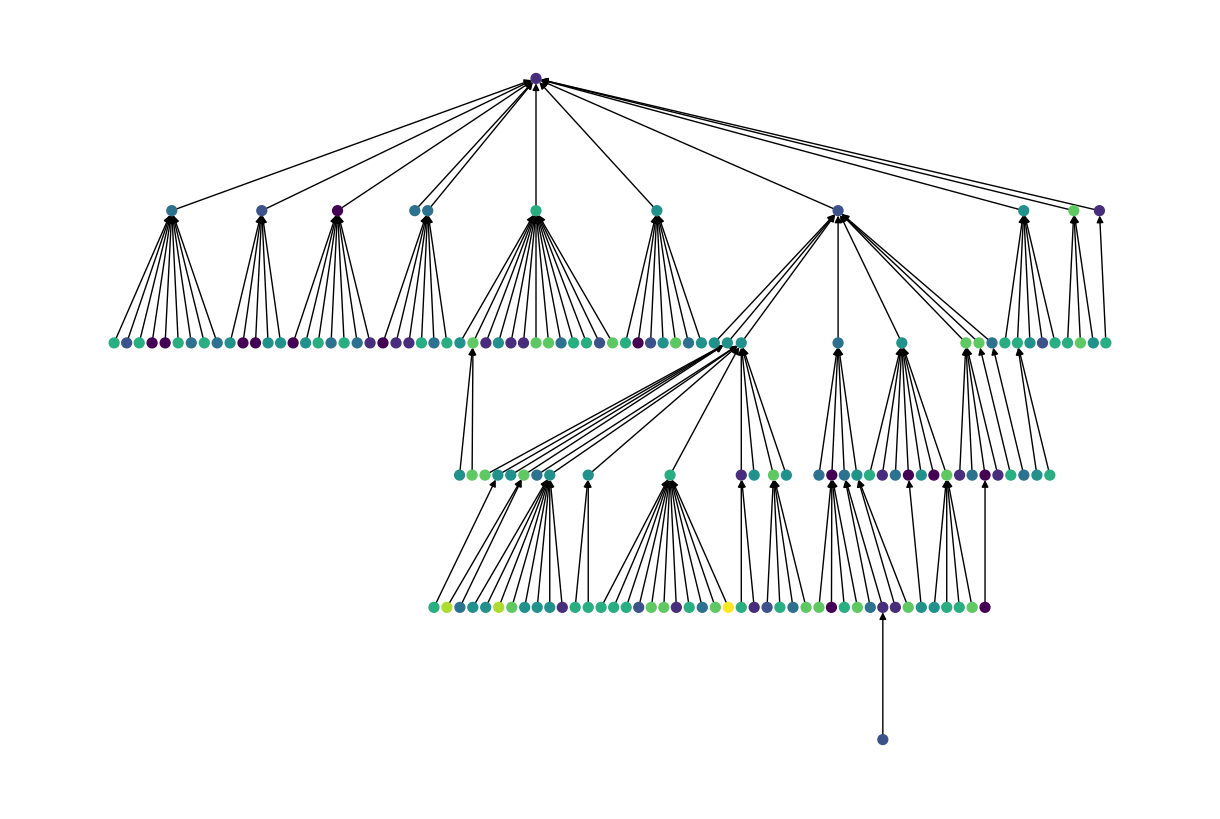

In [122]:
community = [i for i in nx.community.louvain_communities(weighted_network)]
colors = [create_node_to_partition_mapping(community)[n] for n in weighted_network.nodes]

print(f'Modularity: {nx.community.quality.modularity(weighted_network, community)}')

plt.figure(figsize=(12, 8))
pos_hierarchic = nx.nx_agraph.graphviz_layout(H, prog='dot')
pos_hierarchic = {node: (x,-y) for (node, (x,y)) in pos_hierarchic.items()}
nx.draw(H, pos=pos_hierarchic, with_labels=False, arrows=True, node_size=50, node_color=colors)

plt.show()

Communities based on Girvan-Newman algorithm

Modularity: 0.04271773402494706


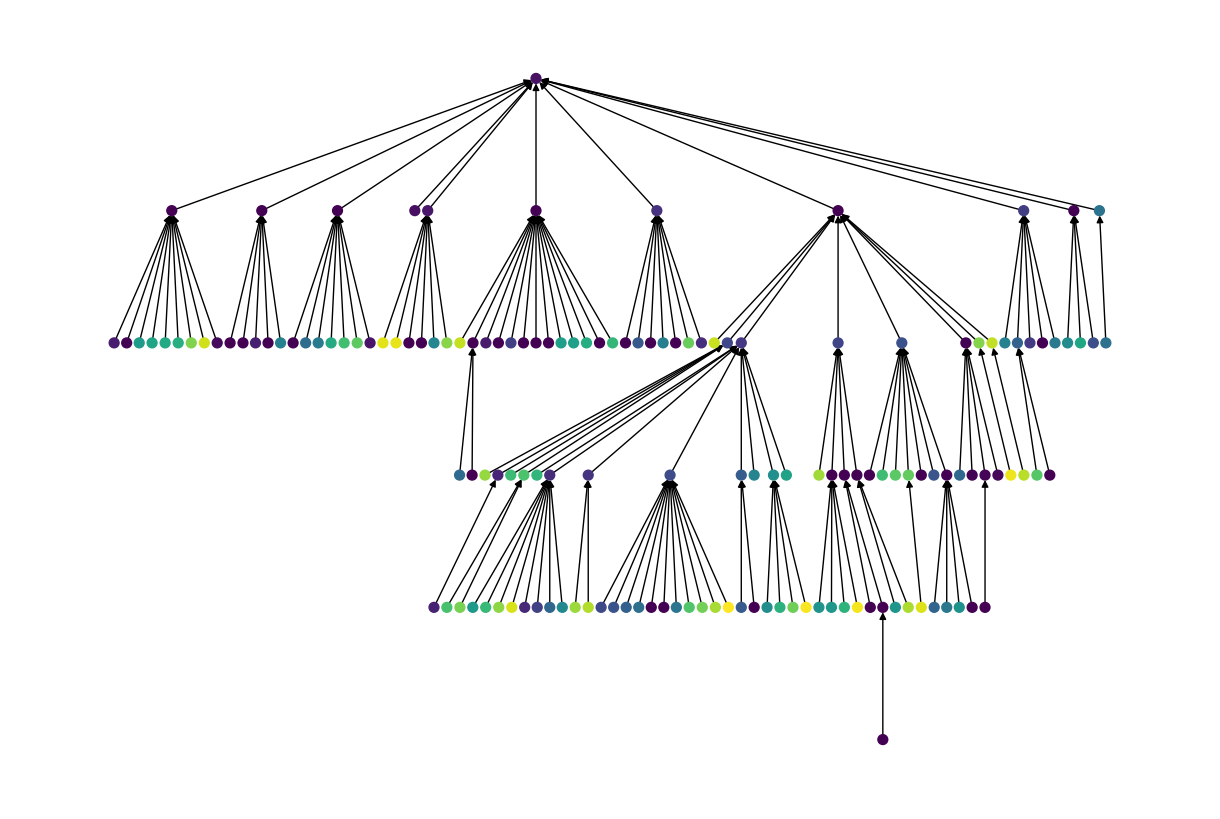

In [126]:
comms = [i for i in nx.algorithms.community.girvan_newman(weighted_network)]
best = max(comms, key=lambda part: nx.community.quality.modularity(weighted_network, part))
colors = [create_node_to_partition_mapping(best)[n] for n in weighted_network.nodes]

print(f'Modularity: {nx.community.quality.modularity(weighted_network, best)}')

plt.figure(figsize=(12, 8))
pos_hierarchic = nx.nx_agraph.graphviz_layout(H, prog='dot')
pos_hierarchic = {node: (x,-y) for (node, (x,y)) in pos_hierarchic.items()}
nx.draw(H, pos=pos_hierarchic, with_labels=False, arrows=True, node_size=50, node_color=colors)

plt.show()

#### Conclusions

Girvan-Newman algorithm takes much more time to get resulting partitions of the input graph. Louvain algorithm results in much better modularity.  
Both methods take edge weights into consideration.  

The resulting partition with higher modularity we can see, that nodes from all levels of hierarchy combine into communities - employees from the most bottom levels are in the same community as those from the top levels.  

Such analysis could be benefitial in companies to detect communities between employees and improve integration between employers and employees by improving communication between people from different communities.